# Importing packages

In [1]:
import numpy as np
import sys
sys.path.insert(0, "../src/")
import jax.numpy as jnp
import oracle
from data_processing import download_and_process_data
from compression_operator import Top_k
import algorithms
from copy import deepcopy
from matplotlib import pyplot as plt
import pickle
import matplotlib.patches as mpatches
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.ticker as tck

# Phishing

## Download and modify the dataset

In [3]:
num_clients = 20

In [4]:
lambda_ = 0.1

In [5]:
dataset_name = 'phishing'

In [6]:
X, y, data = download_and_process_data(dataset_name, num_clients)

Dataset is downloaded.
Data is evenly divided between 20 clients


In [7]:
d = X.shape[1]

## Create oracles

In [8]:
oracle_container = oracle.NoncvxLogRegContainer(data, lambda_)
L = oracle_container.compute_smoothness()
L_tilde = oracle_container.compute_distributed_smoothness()
print('Oracle used is {}. Smoothness constant (L) is {}. Distributed \
smoothness (L_tilde) is {}.'.format(oracle_container.__class__.__name__, L,
                                    L_tilde))

Oracle used is NoncvxLogRegContainer. Smoothness constant (L) is 0.36256536797623107. Distributed smoothness (L_tilde) is 0.36609956525744064.


# Run algorithms

In [9]:
stepsize_scales = 2 ** np.arange(0, 10, 2)

In [10]:
stepsize_scales

array([  1,   4,  16,  64, 256])

In [11]:
x_0 = jnp.zeros(d)

In [12]:
max_comm = 10000

In [13]:
zetas = np.geomspace(2 ** -8, 2 ** 8, 10)

In [14]:
zetas

array([3.90625000e-03, 1.33944372e-02, 4.59292029e-02, 1.57490131e-01,
       5.40029869e-01, 1.85174942e+00, 6.34960421e+00, 2.17726400e+01,
       7.46578585e+01, 2.56000000e+02])

In [15]:
zetas = np.insert(zetas, 0, 0)

In [16]:
zetas

array([0.00000000e+00, 3.90625000e-03, 1.33944372e-02, 4.59292029e-02,
       1.57490131e-01, 5.40029869e-01, 1.85174942e+00, 6.34960421e+00,
       2.17726400e+01, 7.46578585e+01, 2.56000000e+02])

In [17]:
ks = [1, int(d / 4), int(d/2), d]

In [18]:
time_limit = 100

### EF21

In [19]:
histories = dict()

In [20]:
comm = Top_k(d)
comm.compress(x_0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
adaptive=True
histories = {}
#stepsize_scales = np.arange(16, 256, 16)
for k in [ks[0], ks[-1]]:
    if adaptive:
        c_op = Top_k(d//2)
    else:
        c_op = Top_k(k)
    beta = c_op.beta(d)
    theta = c_op.theta(d)
    beta_w = max(zeta, beta)
    c_op_master = Top_k(master_c)
    beta_m = c_op_master.beta(d)
    theta_m = c_op_master.theta(d)
    for zeta in zetas:
        theoretical_stepsize = 1. / (L + L_tilde * np.sqrt(6*beta_m*(beta_w + 1) / theta_m + 2 * beta_w / theta_m * (1 + 3*beta_m*(2 - theta) / theta_m)))
        history_best = [np.float32('inf')]
        history_comm_best = None
        best_scale = None
        for stepsize_scale in stepsize_scales[:]:
            print('{}-{}-{}'.format(k, zeta, stepsize_scale))
            stepsize = stepsize_scale * theoretical_stepsize
            history, history_comm, compressors = algorithms.biCLAG(x_0,
                                                    oracle_container,
                                                    c_op,
                                                    stepsize,
                                                    zeta,
                                                    max_comm,
                                                    time_limit,
                                                    adaptive=adaptive, master_c=master_c)
            print('')
#             if history[-1] < history_best[-1]:
#                 history_best = deepcopy(history)
#                 history_comm_best = deepcopy(history_comm)
#                 best_scale = stepsize_scale
            histories[(k, zeta, stepsize_scale)] = (history_comm, history, stepsize_scale, compressors)
        with open('../results/histories_{}_{}_{}_2605_bi_2.pickle'.format(dataset_name, adaptive, num_clients), 'wb') as file:
            pickle.dump(histories, file)

1-0.0-1
Currently communicated 10200 float numbers
1-0.0-4
Currently communicated 10200 float numbers
1-0.0-16
Currently communicated 10200 float numbers
1-0.0-64
Currently communicated 10200 float numbers
1-0.0-256
Currently communicated 10200 float numbers
1-0.00390625-1
Currently communicated 10200 float numbers
1-0.00390625-4
Currently communicated 10200 float numbers
1-0.00390625-16
Currently communicated 10200 float numbers
1-0.00390625-64
Currently communicated 10200 float numbers
1-0.00390625-256
Currently communicated 10200 float numbers
1-0.013394437232079259-1
Currently communicated 10200 float numbers
1-0.013394437232079259-4
Currently communicated 10200 float numbers
1-0.013394437232079259-16
Currently communicated 10200 float numbers
1-0.013394437232079259-64
Currently communicated 10200 float numbers
1-0.013394437232079259-256
Currently communicated 10200 float numbers
1-0.04592920288361246-1
Currently communicated 10200 float numbers
1-0.04592920288361246-4
Currently co

In [37]:
adaptive=False
master_c = 1
histories = {}
#stepsize_scales = np.arange(16, 256, 16)
for k in [ks[0], ks[-1]]:
    if adaptive:
        c_op = Top_k(d//2)
    else:
        c_op = Top_k(k)
    beta = c_op.beta(d)
    theta = c_op.theta(d)
    beta_w = max(zeta, beta)
    c_op_master = Top_k(master_c)
    beta_m = c_op_master.beta(d)
    theta_m = c_op_master.theta(d)
    for zeta in zetas:
        theoretical_stepsize = 1. / (L + L_tilde * np.sqrt(6*beta_m*(beta_w + 1) / theta_m + 2 * beta_w / theta_m * (1 + 3*beta_m*(2 - theta) / theta_m)))
        history_best = [np.float32('inf')]
        history_comm_best = None
        best_scale = None
        for stepsize_scale in stepsize_scales[:]:
            print('{}-{}-{}'.format(k, zeta, stepsize_scale))
            stepsize = stepsize_scale * theoretical_stepsize
            history, history_comm, compressors = algorithms.biCLAG(x_0,
                                                    oracle_container,
                                                    c_op,
                                                    stepsize,
                                                    zeta,
                                                    max_comm,
                                                    time_limit,
                                                    adaptive=adaptive, master_c=master_c)
            print('')
#             if history[-1] < history_best[-1]:
#                 history_best = deepcopy(history)
#                 history_comm_best = deepcopy(history_comm)
#                 best_scale = stepsize_scale
            histories[(k, zeta, stepsize_scale)] = (history_comm, history, stepsize_scale, compressors)
        with open('../results/histories_{}_{}_{}_2605_bi_2.pickle'.format(dataset_name, adaptive, num_clients), 'wb') as file:
            pickle.dump(histories, file)

1-0.0-1
Currently communicated 10000 float numbers
1-0.0-4
Currently communicated 10000 float numbers
1-0.0-16
Currently communicated 10000 float numbers
1-0.0-64
Currently communicated 10000 float numbers
1-0.0-256
Currently communicated 10000 float numbers
1-0.00390625-1
Currently communicated 10000 float numbers
1-0.00390625-4
Currently communicated 10000 float numbers
1-0.00390625-16
Currently communicated 10000 float numbers
1-0.00390625-64
Currently communicated 10000 float numbers
1-0.00390625-256
Currently communicated 10000 float numbers
1-0.013394437232079259-1
Currently communicated 10000 float numbers
1-0.013394437232079259-4
Currently communicated 10000 float numbers
1-0.013394437232079259-16
Currently communicated 10000 float numbers
1-0.013394437232079259-64
Currently communicated 10000 float numbers
1-0.013394437232079259-256
Currently communicated 10000 float numbers
1-0.04592920288361246-1
Currently communicated 10000 float numbers
1-0.04592920288361246-4
Currently co

In [40]:
theoretical_stepsize

4.435150127336584e-05

In [41]:
adaptive=False
histories = {}
#stepsize_scales = np.arange(16, 256, 16)
for k in ks[:]:
    if adaptive:
        c_op = Top_k(1)
    else:
        c_op = Top_k(k)
    beta = c_op.beta(d)
    theta = c_op.theta(d)
    for zeta in zetas[:]:
        theoretical_stepsize = 1. / (L + L_tilde * np.sqrt(
            max(zeta, beta) / theta))
        history_best = [np.float32('inf')]
        history_comm_best = None
        best_scale = None
        for stepsize_scale in stepsize_scales[:]:
            print('{}-{}-{}'.format(k, zeta, stepsize_scale))
            stepsize = stepsize_scale * theoretical_stepsize
            history, history_comm, compressors = algorithms.new_CLAG(x_0,
                                                    oracle_container,
                                                    c_op,
                                                    stepsize,
                                                    zeta,
                                                    max_comm, L, L_tilde,
                                                    time_limit/10)
            print('')
#             if history[-1] < history_best[-1]:
#                 history_best = deepcopy(history)
#                 history_comm_best = deepcopy(history_comm)
#                 best_scale = stepsize_scale
            histories[(k, zeta, stepsize_scale)] = (history_comm, history, stepsize_scale, compressors)
        with open('../results/histories_{}_{}_{}_0805_adaptive_lipshz.pickle'.format(dataset_name, adaptive, num_clients), 'wb') as file:
            pickle.dump(histories, file)

1-0.0-1


KeyboardInterrupt: 

In [42]:
theoretical_stepsize

0.020160364033663867

In [73]:
a = np.zeros([10,20])
b = np.zeros([10,20])
np.linalg.norm(a,ord=2,axis=1).shape

(10,)

In [ ]:
with open('../results/histories_phishing.pickle', 'rb') as file:
    histories_2 = pickle.load(file)

In [ ]:
histories_full = {**histories, **histories_2}

In [ ]:
with open('../results/histories_phishing.pickle', 'wb') as file:
    pickle.dump(histories_full, file)

In [ ]:
histories = deepcopy(histories_full)

# Plots

In [50]:
with open('../results/histories_{}_2.pickle'.format(dataset_name), 'rb') as file:
    histories = pickle.load(file)

In [51]:
float_bits = 32

In [52]:
bit_scale = 1000

In [53]:
histories_2 = {}
for k, v in histories.items():
    comm, norm, scale = v
    comm_ = [x * float_bits / (num_clients * bit_scale) for x in comm]
    norm_ = [x ** 2 for x in norm]
    histories_2[k] = (comm_, norm_, scale)

In [54]:
ks = [1, int(d / 4), int(d/2), d]

In [55]:
zetas = np.geomspace(2 ** -8, 2 ** 8, 3)
zetas = np.insert(zetas, 0, 0)

In [31]:
size = 40
marker_size = 30
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 4
# plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.labelsize'] = size  # 40
plt.rcParams['ytick.labelsize'] = size  # 40
plt.rcParams['legend.fontsize'] = 30  # 30
plt.rcParams['axes.titlesize'] = size  # 40
plt.rcParams['axes.labelsize'] = size  # 40
plt.rcParams["figure.figsize"] = [50, 20]

In [98]:
with open('../results/histories_{}_{}_{}_0205_new.pickle'.format(dataset_name, False, num_clients), 'rb') as file:
    histories_aclag = pickle.load(file)
with open('../results/histories_{}_{}_{}_0205.pickle'.format(dataset_name, False, num_clients), 'rb') as file:
    histories_clag = pickle.load(file)
    

NameError: name 'histories_2' is not defined

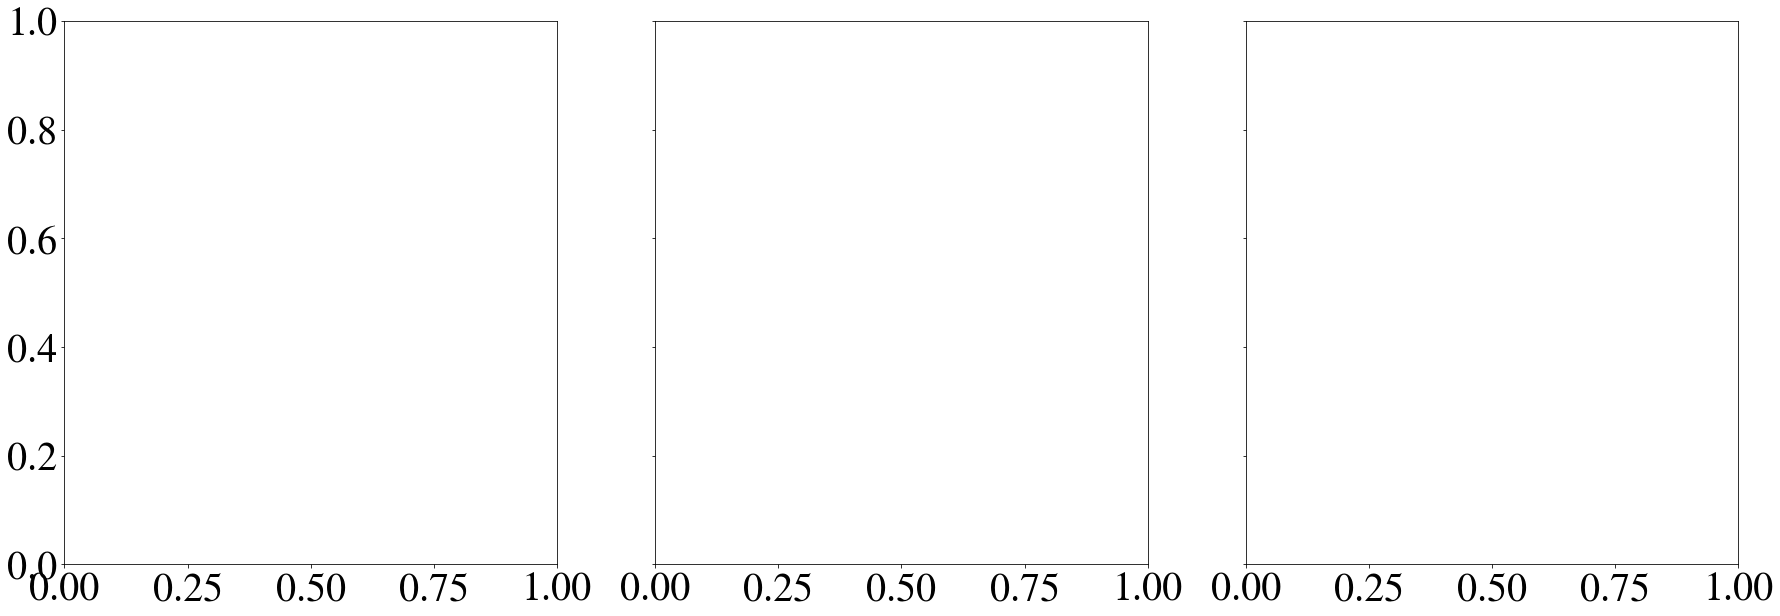

In [99]:
fig, ax = plt.subplots(nrows=1, ncols=len(ks) - 1, figsize=(30, 10),
                       sharey=True)
# LAG
best_zeta_lag = zetas[1]
for zeta in zetas[2:]:
    if histories_2[(d, zeta)][1][-1] < histories_2[(d, best_zeta_lag)][1][-1]:
        best_zeta = zeta
comm_lag, norm_lag, scale_lag = histories_2[(d, best_zeta_lag)]
for k_id, k in enumerate(ks[:-1]):
    print(k)
    # EF21
    comm_ef21, norm_ef21, scale_ef21 = histories_2[(k, 0)]
    ax[k_id].plot(comm_ef21, norm_ef21, label='EF21 {}x'.format(scale_ef21),
                  marker='>', markevery=int(len(comm_ef21) / 5), ms=30)
    # LAG
    ax[k_id].plot(
        comm_lag,
        norm_lag,
        label='LAG {}x, $\zeta=${}'.format(scale_lag, round(best_zeta_lag, 4)),
        marker='<',
        markevery=int(len(comm_lag) / 10) + 1,
        ms=30
    )
    # CLAG
    best_zeta = zetas[1]
    for zeta in zetas[2:]:
        if histories_2[(k, zeta)][1][-1] < histories_2[(k, best_zeta)][1][-1]:
            best_zeta = zeta
    comm_clag, norm_clag, scale_clag = histories_2[(k, best_zeta)]
    locmin = tck.LogLocator(base=10.0, subs=(
        0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8), numticks=10)
    ax[k_id].plot(comm_clag,
                  norm_clag,
                  label='CLAG {}x, $\zeta=${}'.format(
                    scale_clag, round(best_zeta, 4)),
                  marker='*',
                  markevery=int(len(comm_clag) / 10) + 2,
                  ms=30)
    ax[k_id].set_yscale('log')
    ax[k_id].set_xlabel('#Mbits/n')
    if k_id == 0:
        ax[k_id].set_ylabel(r'$||\nabla f(x^t)||^2$')
    ax[k_id].legend(loc="best", framealpha=0.5)
    ax[k_id].grid()
    ax[k_id].locator_params(axis='x', nbins=4)
    ax[k_id].xaxis.set_minor_locator(tck.AutoMinorLocator(5))
    ax[k_id].yaxis.set_minor_locator(locmin)
    ax[k_id].yaxis.set_tick_params(which='both',
                                   direction='out',
                                   labelbottom=True)
    ax[k_id].set_yticks(np.geomspace(1e-11, 1e-1, 6))
    ax[k_id].set_title('k = {}'.format(k))
    fig.tight_layout()
    fig.savefig('../plots/plot_{}.pdf'.format(dataset_name))

In [113]:
with open('../results/histories_{}_True3.pickle'.format(dataset_name), 'rb') as file:
    histories = pickle.load(file)
with open('../results/histories_{}_False.pickle'.format(dataset_name), 'rb') as file:
    histories_clag = pickle.load(file)

KeyError: (68, 0.1574901312368592)

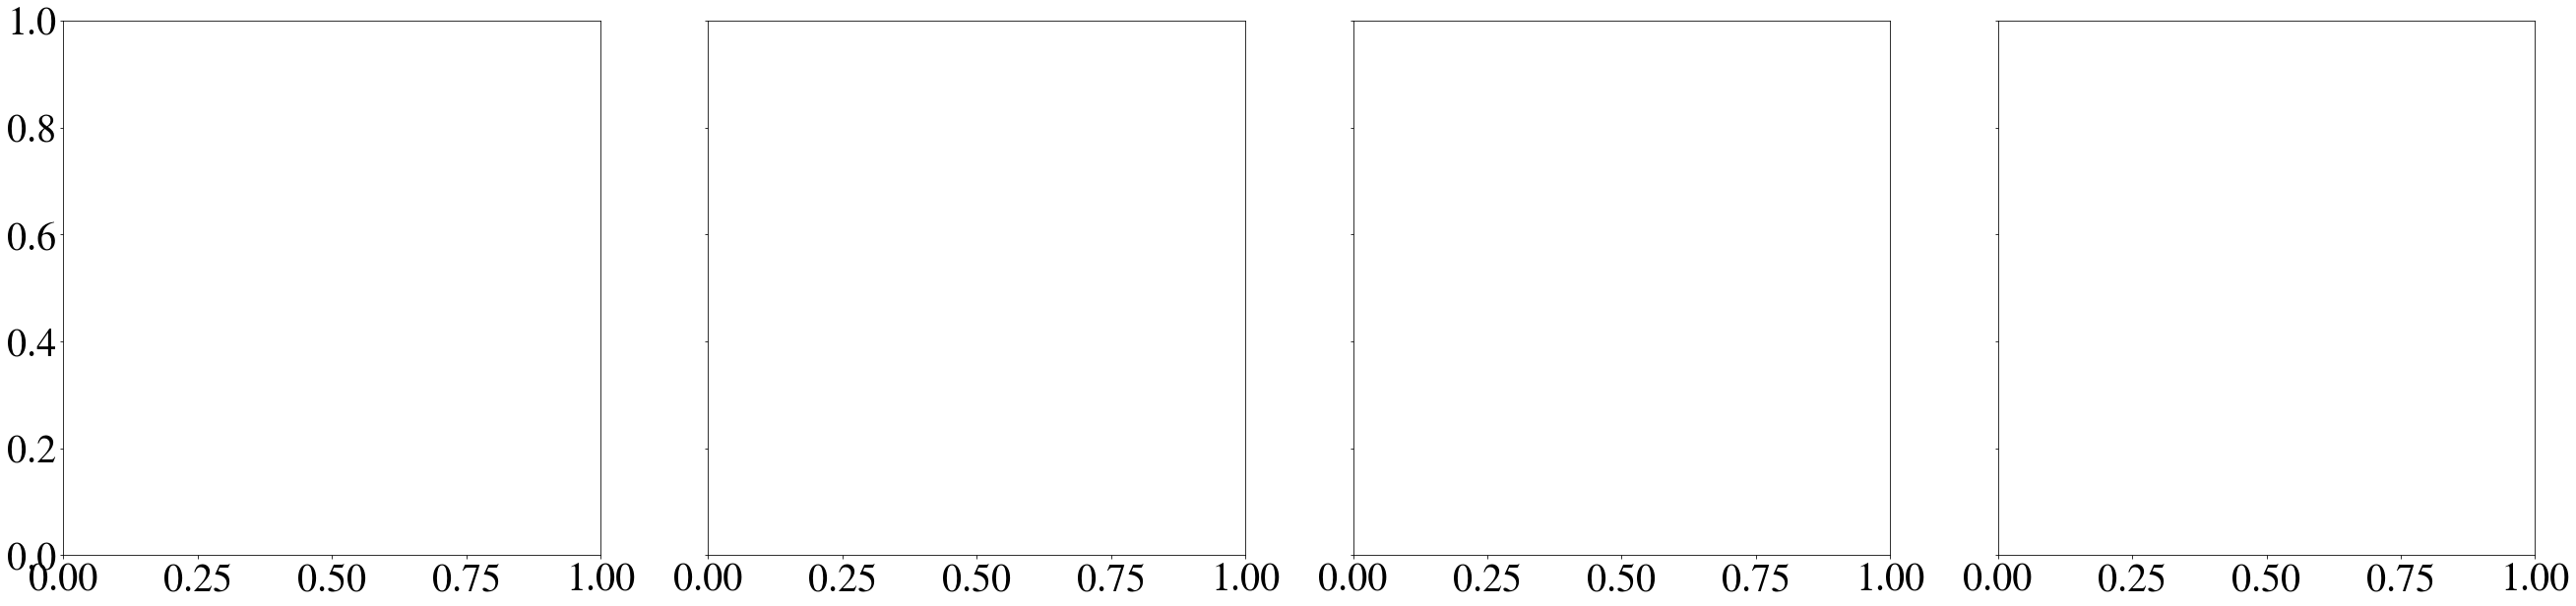

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=len(ks), figsize=(45, 10),
                       sharey=True)

z = zetas[3]
comm_lag, norm_lag, scale_lag = histories_clag[(d, z)]

for k_id, k in enumerate(ks):
    print(k)
    # EF21
    comm_ef21, norm_ef21, scale_ef21 = histories_clag[(k, 0)]
    ax[k_id].plot(comm_ef21, norm_ef21, label='EF21',
                  marker='>', markevery=int(len(comm_ef21) / 5), ms=30)
    # LAG
    ax[k_id].plot(
        comm_lag,
        norm_lag,
        label='LAG',
        marker='<',
        markevery=int(len(comm_lag) / 10) + 1,
        ms=30
    )
    # CLAG
    comm_clag, norm_clag, scale_clag = histories_clag[(k, z)]
    locmin = tck.LogLocator(base=10.0, subs=(
        0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8), numticks=10)
    ax[k_id].plot(comm_clag,
                  norm_clag,
                  label='CLAG',
                  marker='*',
                  markevery=int(len(comm_clag) / 10) + 2,
                  ms=30)
    comm_alag, norm_alag, scale_alag = histories[(k, z)]
    ax[k_id].plot(comm_alag,
              norm_alag,
              label='aCLAG',
              marker='*',
              markevery=int(len(comm_clag) / 10) + 2,
              ms=30)
    ax[k_id].set_yscale('log')
    ax[k_id].set_xlabel('#Mbits/n')
    if k_id == 0:
        ax[k_id].set_ylabel(r'$||\nabla f(x^t)||^2$')
    ax[k_id].legend(loc="best", framealpha=0.5)
    ax[k_id].grid()
    ax[k_id].locator_params(axis='x', nbins=4)
    ax[k_id].xaxis.set_minor_locator(tck.AutoMinorLocator(5))
    ax[k_id].yaxis.set_minor_locator(locmin)
    ax[k_id].yaxis.set_tick_params(which='both',
                                   direction='out',
                                   labelbottom=True)
    #ax[k_id].set_yticks(np.geomspace(1e-11, 1e-1, 6))
    ax[k_id].set_title('k = {}'.format(k))
    fig.show()
    fig.tight_layout()
    #fig.savefig('../plots/plot_{}_{}.pdf'.format(dataset_name,round(z,4)))

In [198]:
c_op = Top_k(20)
beta = c_op.beta(d)
theta = c_op.theta(d)
theoretical_stepsize = 1. / (L + L_tilde * np.sqrt(
    max(zeta, beta) / theta))
theoretical_stepsize

0.010087551425125154

In [200]:
with open('../results/histories_{}_True_init.pickle'.format(dataset_name), 'rb') as file:
    histories1 = pickle.load(file)
with open('../results/histories_{}_True_init2.pickle'.format(dataset_name), 'rb') as file:
    histories2 = pickle.load(file)
with open('../results/histories_{}_True_init3.pickle'.format(dataset_name), 'rb') as file:
    histories3 = pickle.load(file)
with open('../results/histories_{}_True_init_noskip.pickle'.format(dataset_name), 'rb') as file:
    histories_noskip = pickle.load(file)
with open('../results/histories_{}_True6.pickle'.format(dataset_name), 'rb') as file:
    histories_nograd = pickle.load(file)
with open('../results/histories_{}_True_1904.pickle'.format(dataset_name), 'rb') as file:
    histories = pickle.load(file)
# with open('../results/histories_{}_True_1304.pickle'.format(dataset_name), 'rb') as file:
#     histories = pickle.load(file)
with open('../results/histories_{}_False5.pickle'.format(dataset_name), 'rb') as file:
    histories_clag = pickle.load(file)
# with open('../results/histories_{}_False_1804.pickle'.format(dataset_name), 'rb') as file:
#     histories_clag = pickle.load(file)

In [300]:
communications = np.stack(histories[(ks[0], zetas[8], stepsize_scales[3])][-1][1:],axis=0)

([<matplotlib.patches.Wedge at 0x15261807af28>,
 [Text(1.1, 0.0, 'skipped'),
  Text(1.0706761979349988, 0.25229442953710945, 'full'),
  Text(-1.0706761802188642, -0.2522945047200639, 'compressed')])

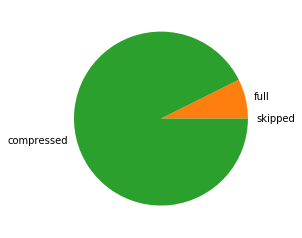

In [27]:
def merge_histories(*histories):
    if len(histories) < 2:
        return histories[0]
    else:
        merged = histories[0].copy()
        history = merge_histories(*histories[1:])
        for key in history:
            if key not in merged:
                merged[key] = history[key]
    return merged
                

def find_optimal_stepsize(history, max_scaling=None):
    optimal = {}
    for key in history:
        if key[:2] not in optimal or (history[key][1][-1] < optimal[key[:2]][1][-1] and (max_scaling is None or key[-1] <= max_scaling)):
            opt_scaling = key[-1]
            optimal[key[:2]] = history[key]
            optimal[key[:2]] = (optimal[key[:2]][0], optimal[key[:2]][1], opt_scaling, optimal[key[:2]][-1])
    return optimal

iters, comms = histories[(ks[0], zetas[8], stepsize_scales[2])][:2]
communications = np.stack(histories[(ks[0], zetas[9], stepsize_scales[4])][-1][1:],axis=0)
bins = np.bincount(communications.flatten())
skip, full = bins[0], bins[-1]
rest = bins.sum() - skip - full
plt.pie([skip, full, rest], labels=['skipped', 'full', 'compressed'])

In [28]:
histories = merge_histories(histories1, histories2, histories3)
#histories = histories_noskip
#histories = histories_nograd
optimal = find_optimal_stepsize(histories)
optimal_clag = find_optimal_stepsize(histories_clag)
def plot_pie(communications, ax=None, title='', colors=None):
    if ax is None:
        ax = plt.gca()
    communications = np.stack(communications[1:],axis=0)
    bins = np.bincount(communications.flatten())
    skip, full = bins[0], bins[-1]
    rest = bins.sum() - skip - full
    ax.set_title(title)
    ax.pie([skip, full, rest], colors=colors)
    
def plot_hist(communications, ax=None, title=''):
    if ax is None:
        ax = plt.gca()
    communications = np.stack(communications[1:],axis=0)
    rrange = list(range(0,d,5))
    rrange.append(d)
    rrange.insert(1, 1)
    N, bins, patches = ax.hist(communications.flatten(), bins=rrange, align='left', color='C2')
    ax.set_xlim(-1,d)
    ax.set_ylim(0,np.max(bins))
    ax.set_xlabel('k')
    patches[0].set_facecolor('C0')
    patches[-1].set_facecolor('C1')
    ax.set_title(title)
    

#plot_pie(optimal[(ks[0], zetas[0])][-1])
plot_hist(optimal[(ks[0], zetas[6])][-1])

NameError: name 'histories1' is not defined

In [174]:
com

68

In [46]:
with open('../results/histories_{}_{}_{}_2605_bi_2.pickle'.format(dataset_name, True, 20), 'rb') as file:
    histories_aclag = pickle.load(file)
with open('../results/histories_{}_{}_{}_2605_bi_2.pickle'.format(dataset_name, False, 20), 'rb') as file:
    histories_clag = pickle.load(file)
# with open('../results/histories_{}_{}_{}_1905.pickle'.format(dataset_name, True, 20), 'rb') as file:
#     histories_aef = pickle.load(file)
    
optimal = find_optimal_stepsize(histories_aclag, max_scaling=256)
optimal_clag = find_optimal_stepsize(histories_clag, max_scaling=256)
#optimal_aef = find_optimal_stepsize(histories_aef, max_scaling=16)

KeyError: (22, 0.5400298694461532)

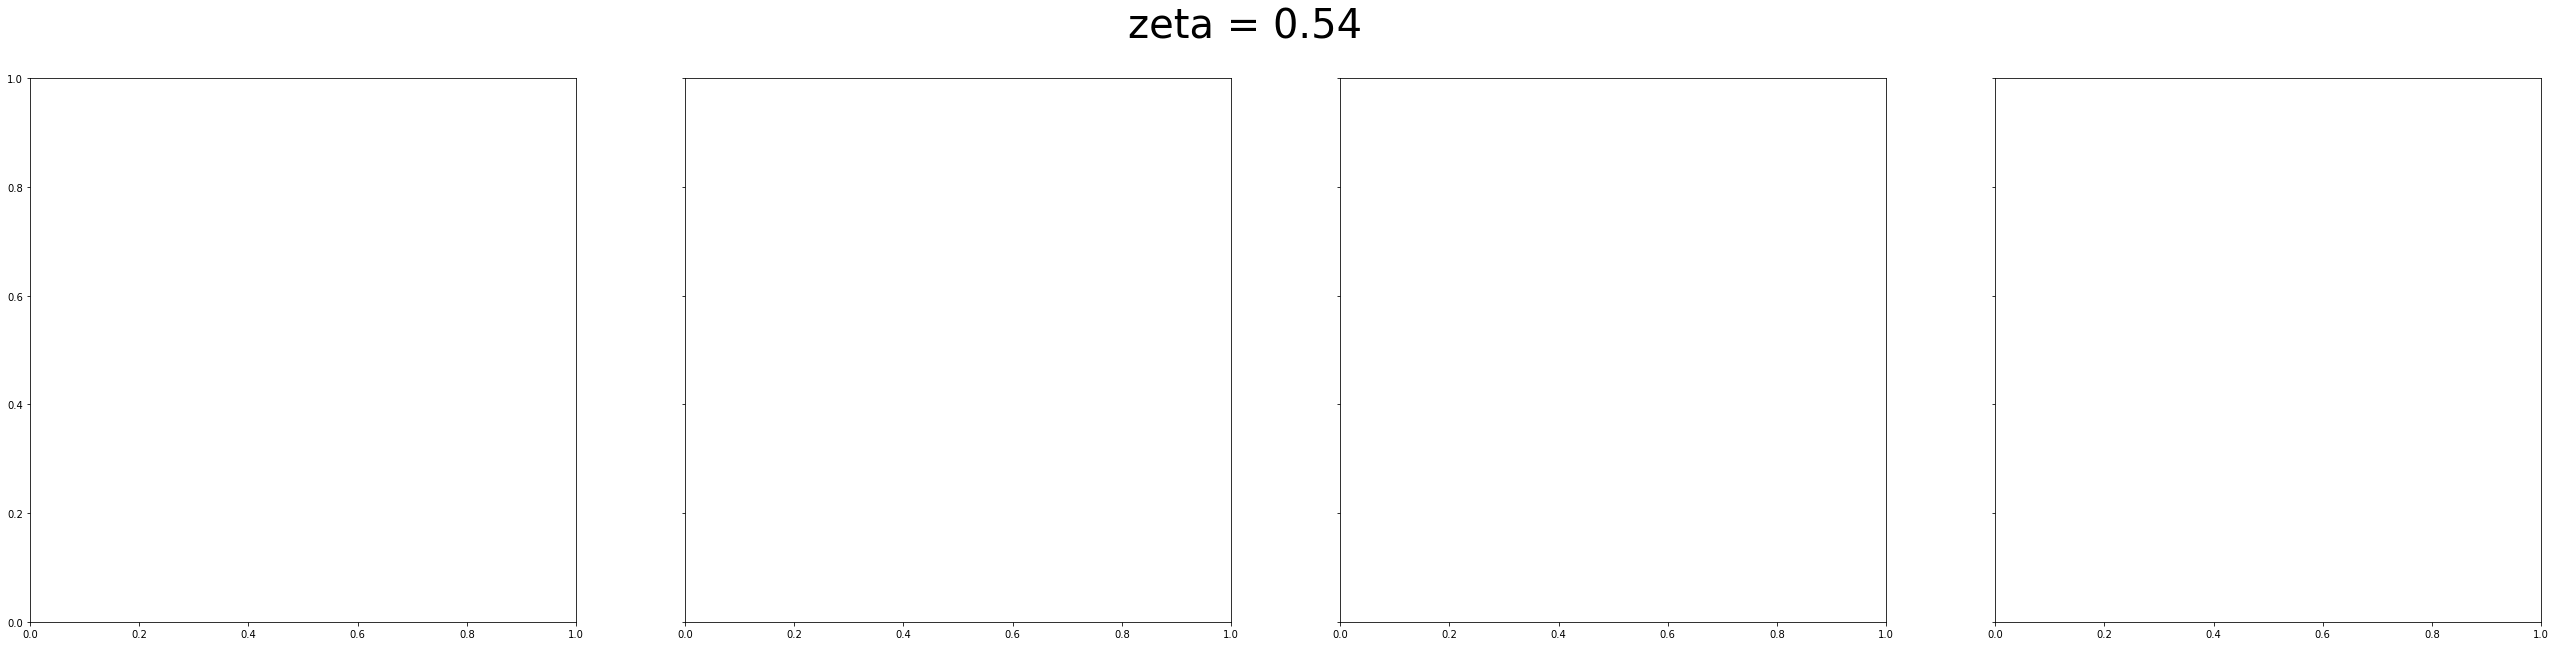

In [90]:
fig, ax = plt.subplots(nrows=1, ncols=len(ks), figsize=(45, 10),
                       sharey=True)

z = zetas[5]
fig.suptitle('zeta = {:.2f}'.format(z), fontsize=40)
comm_lag, norm_lag, scale_lag, c_lag = optimal_clag[(d, z)]

for k_id, k in enumerate(ks[:4]):
    # EF21
    comm_ef21, norm_ef21, scale_ef21, c_ef21 = optimal_clag[(k, 0)]
    ax[k_id].plot(comm_ef21, norm_ef21, label='EF21-x{}'.format(scale_ef21),
                  markevery=int(len(comm_ef21) / 10) + 2)
    # LAG
    ax[k_id].plot(
        comm_lag,
        norm_lag,
        label='LAG-x{}'.format(scale_lag),
        marker='<',
        ms=30
    )
    # CLAG
    comm_clag, norm_clag, scale_clag, c_clag = optimal_clag[(k, z)]
    ax[k_id].plot(comm_clag,
                  norm_clag,
                  label='CLAG-x{}'.format(scale_clag),
                  marker='*',
                  markevery=int(len(comm_clag) / 10) + 2,
                  ms=30)
    comm_alag, norm_alag, scale_alag, c_alag = optimal[(ks[0], z)]
    ax[k_id].plot(comm_alag,
              norm_alag,
              label='AdaCGD-x{}'.format(scale_alag),
              marker='*',
                  markevery=int(len(comm_alag) / 10) + 2,
              ms=30)
    comm_alag, norm_alag, scale_alag, c_alag = optimal_aef[(ks[0], z)]
    ax[k_id].plot(comm_alag,
              norm_alag,
              label='AdaEF-x{}'.format(scale_alag),
              marker='*',
                  markevery=int(len(comm_alag) / 10) + 2,
              ms=30)
    comm_gd, norm_gd, scale_gd, c_gd = optimal_clag[(ks[-1], zetas[0])]
    ax[k_id].plot(comm_gd, norm_gd, label='GD-x{}'.format(scale_gd),
                  marker='>', ms=30)
    ax[k_id].set_yscale('log')
    ax[k_id].set_xlabel('#Mbits/n')
    if k_id == 0:
        ax[k_id].set_ylabel(r'$||\nabla f(x^t)||^2$')
    ax[k_id].legend(loc="best", framealpha=0.5)
    ax[k_id].grid()
    ax[k_id].locator_params(axis='x', nbins=4)
    ax[k_id].xaxis.set_minor_locator(tck.AutoMinorLocator(5))
    #ax[k_id].yaxis.set_minor_locator(locmin)
    ax[k_id].yaxis.set_tick_params(which='both',
                                   direction='out',
                                   labelbottom=True)
    #ax[k_id].set_yticks(np.geomspace(1e-11, 1e-1, 6))
    ax[k_id].set_title('k = {}'.format(k))
    fig.show()
    fig.tight_layout()
    #fig.savefig('../plots/plot_{}_{}_her.pdf'.format(dataset_name,round(z,4)))
    
# fig, ax = plt.subplots(nrows=2, ncols=2*len(ks), figsize=(45, 10),
#                        sharey=True)
# axes = ax.T.reshape(len(ks),4)
# _, _, _, c_alag = optimal[(ks[0], z)]
# _, _, _, c_lag = optimal_clag[(d, z)]
# for k_id, k in enumerate(ks):
#     _, _, _, c_clag = optimal_clag[(k, z)]
#     _, _, _, c_ef21 = optimal_clag[(k, 0)]
#     plot_pie(c_lag, axes[k_id,0], title='LAG', colors=['C0', 'C1'])
#     plot_pie(c_clag, axes[k_id,1], title='CLAG', colors=['C0', 'C2'])
#     plot_pie(c_alag, axes[k_id,2], title='aCLAG', colors=['C0', 'C1', 'C2'])
#     plot_pie(c_ef21, axes[k_id,3], title='EF21', colors=['C0', 'C2'])
#     c0 = mpatches.Patch(color='C0', label='skipped')
#     c1 = mpatches.Patch(color='C1', label='full')
#     c2 = mpatches.Patch(color='C2', label='compressed')
#     fig.legend(handles=[c0,c1,c2])
#     #fig.savefig('../plots/pie_{}_{}_new.pdf'.format(dataset_name,round(z,4)))
    
# fig, ax = plt.subplots(nrows=2, ncols=2*len(ks), figsize=(45, 10),
#                        sharey=True)
# axes = ax.T.reshape(len(ks),4)
# _, _, _, c_alag = optimal[(ks[0], z)]
# _, _, _, c_lag = optimal_clag[(d, z)]
# for k_id, k in enumerate(ks):
#     _, _, _, c_clag = optimal_clag[(k, z)]
#     _, _, _, c_ef21 = optimal_clag[(k, 0)]
#     plot_hist(c_lag, axes[k_id,0], title='LAG')
#     plot_hist(c_clag, axes[k_id,1], title='CLAG')
#     plot_hist(c_alag, axes[k_id,2], title='aCLAG')
#     plot_hist(c_ef21, axes[k_id,3], title='EF21')
#     fig.legend(handles=[c0,c1,c2])

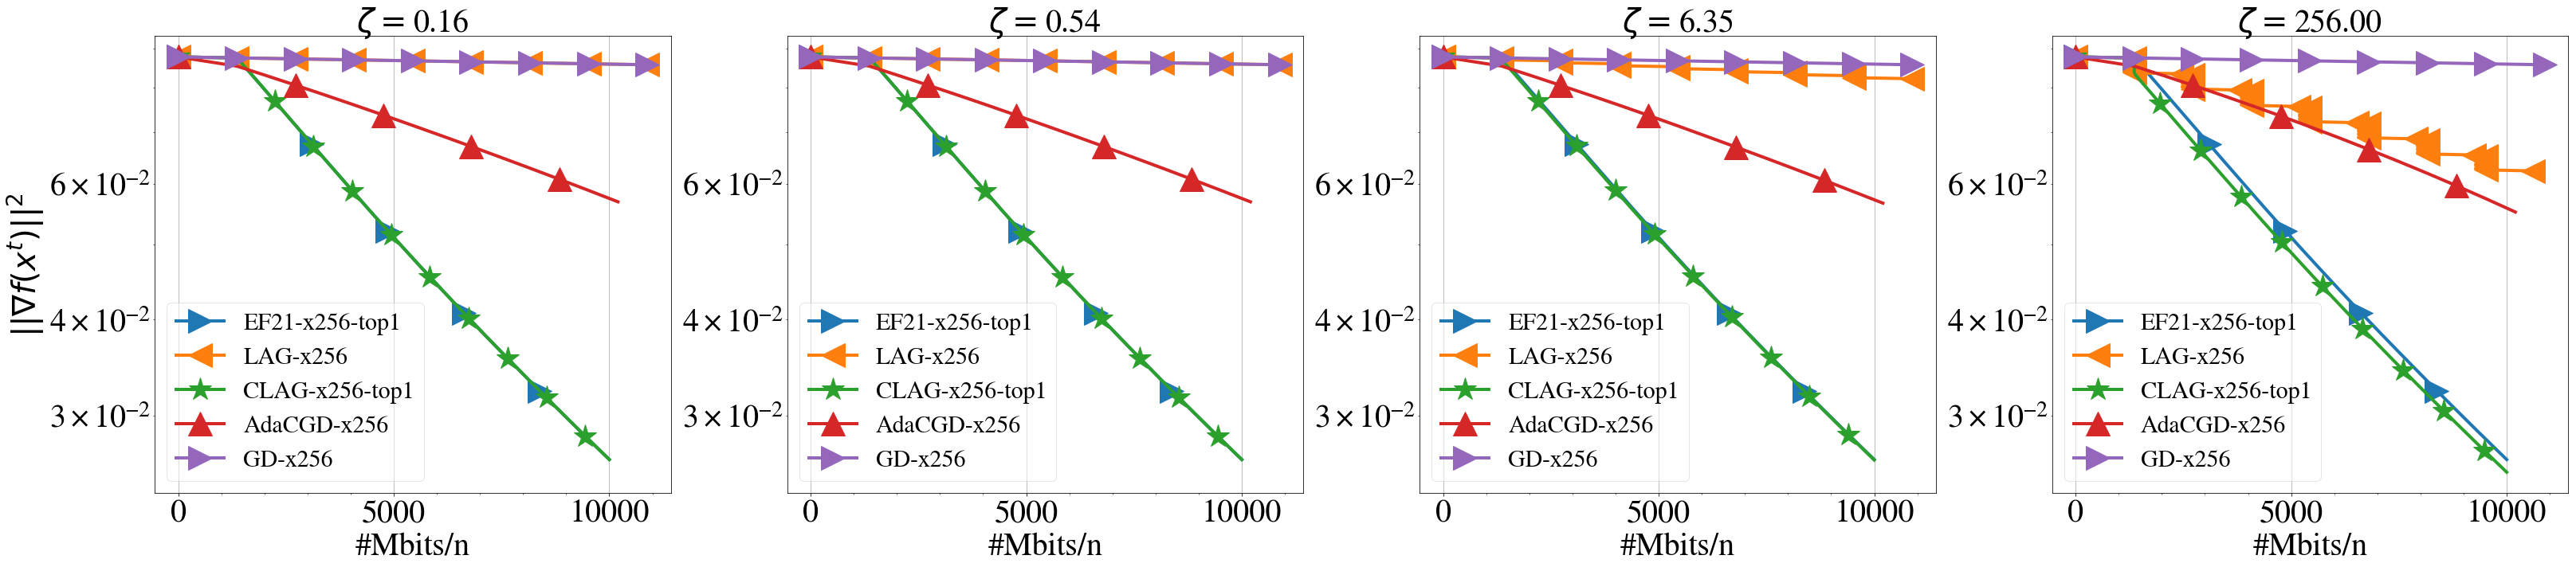

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=len(ks), figsize=(45, 10),
                       sharey=True)

z = zetas[5]
comm_lag, norm_lag, scale_lag, c_lag = optimal_clag[(d, z)]

for z_id, z in enumerate(zetas[[4,5,7,10]]):
    # EF21
    comm_ef21, norm_ef21, scale_ef21, c_ef21 = optimal_clag[(1, 0)]
    ax[z_id].plot(comm_ef21, norm_ef21, label='EF21-x{}-top1'.format(scale_ef21),
                  markevery=int(len(comm_ef21) / 5) + 2, marker='>', ms=30)
    # LAG
    comm_lag, norm_lag, scale_lag, c_lag = optimal_clag[(d, z)]
    ax[z_id].plot(
        comm_lag,
        norm_lag,
        label='LAG-x{}'.format(scale_lag),
        marker='<',
        ms=30
    )
    # CLAG
    comm_clag, norm_clag, scale_clag, c_clag = optimal_clag[(1, z)]
    ax[z_id].plot(comm_clag,
                  norm_clag,
                  label='CLAG-x{}-top{}'.format(scale_clag,1),
                  marker='*',
                  markevery=int(len(comm_clag) / 10) + 2,
                  ms=30)
    comm_alag, norm_alag, scale_alag, c_alag = optimal[(ks[0], z)]
    ax[z_id].plot(comm_alag,
              norm_alag,
              label='AdaCGD-x{}'.format(scale_alag),
              marker='^',
                  markevery=int(len(comm_alag) / 10) + 2,
              ms=30)
#     comm_alag, norm_alag, scale_alag, c_alag = optimal_aef[(ks[0], z)]
#     ax[k_id].plot(comm_alag,
#               norm_alag,
#               label='AdaEF-x{}'.format(scale_alag),
#               marker='*',
#                   markevery=int(len(comm_alag) / 10) + 2,
#               ms=30)
    comm_gd, norm_gd, scale_gd, c_gd = optimal_clag[(d, zetas[0])]
    ax[z_id].plot(comm_gd, norm_gd, label='GD-x{}'.format(scale_gd),
                  marker='>', ms=30)
    ax[z_id].set_yscale('log')
    ax[z_id].set_xlabel('#Mbits/n')
    if z_id == 0:
        ax[z_id].set_ylabel(r'$||\nabla f(x^t)||^2$')
    ax[z_id].legend(loc="best", framealpha=0.5)
    ax[z_id].grid()
    ax[z_id].locator_params(axis='x', nbins=4)
    ax[z_id].xaxis.set_minor_locator(tck.AutoMinorLocator(5))
    #ax[k_id].yaxis.set_minor_locator(locmin)
    ax[z_id].yaxis.set_tick_params(which='both',
                                   direction='out',
                                   labelbottom=True)
    #ax[k_id].set_yticks(np.geomspace(1e-11, 1e-1, 6))
    ax[z_id].set_title('$\zeta =${:.2f}'.format(z))
fig.show()
fig.tight_layout()
#fig.savefig('/home/makam0a/Dropbox/projects/clag/paper/paper/final/plots/adaptive/img_{}.png'.format(dataset_name))

In [658]:
zetas[10], zetas[8], zetas[6], zetas[4]

(256.0, 21.77264000279004, 1.8517494245745807, 0.1574901312368592)

In [228]:
np.max([[1,2,3],[3,4,5]],axis=0)

array([3, 4, 5])

In [412]:
adaptive=True
histories = {}
alpha = 0.5
#stepsize_scales = np.arange(16, 256, 16)
for k in ks[:]:
    c_op = Top_k(k)
    beta = c_op.beta(d)
    theta = c_op.theta(d)
    for zeta in zetas[:]:
        theoretical_stepsize = 1. / (L + L_tilde * np.sqrt(
            max(zeta, beta) / theta))
        history_best = [np.float32('inf')]
        history_comm_best = None
        best_scale = None
        for stepsize_scale in stepsize_scales[:1]:
            print('{}-{}-{}'.format(k, zeta, stepsize_scale))
            stepsize = stepsize_scale * theoretical_stepsize
            history, history_comm, compressors = algorithms.adaptive(x_0,
                                                    oracle_container,
                                                    c_op,
                                                    zeta,
                                                    max_comm,
                                                    time_limit/100, alpha=alpha)
            print('')
#             if history[-1] < history_best[-1]:
#                 history_best = deepcopy(history)
#                 history_comm_best = deepcopy(history_comm)
#                 best_scale = stepsize_scale
            histories[(k, zeta, stepsize_scale)] = (history_comm, history, stepsize_scale, compressors)
        with open('../results/histories_{}_{}_{}_0405_fk_gk.pickle'.format(dataset_name, True, num_clients), 'wb') as file:
            pickle.dump(histories, file)

1-0.0-1
Currently communicated 2540 float numbers
1-0.00390625-1
Currently communicated 2560 float numbers
1-0.013394437232079259-1
Currently communicated 2580 float numbers
1-0.04592920288361246-1
Currently communicated 2560 float numbers
1-0.1574901312368592-1
Currently communicated 2580 float numbers
1-0.5400298694461532-1
Currently communicated 2580 float numbers
1-1.8517494245745807-1
Currently communicated 1360 float numbers
1-6.349604207872803-1
Currently communicated 1360 float numbers
1-21.77264000279004-1
Currently communicated 1360 float numbers
1-74.65785853287149-1
Currently communicated 1360 float numbers
1-256.0-1
Currently communicated 1360 float numbers
17-0.0-1
Currently communicated 10200 float numbers
17-0.00390625-1
Currently communicated 10200 float numbers
17-0.013394437232079259-1
Currently communicated 10200 float numbers
17-0.04592920288361246-1
Currently communicated 10200 float numbers
17-0.1574901312368592-1
Currently communicated 10200 float numbers
17-0.5

In [415]:
with open('../results/histories_{}_{}_{}_0405_fk_gk.pickle'.format(dataset_name, True, 20), 'rb') as file:
    histories_adaptive = pickle.load(file)
    
# with open('../results/histories_{}_{}_{}_2604.pickle'.format(dataset_name, True, 20), 'rb') as file:
#     histories_adaptive = pickle.load(file)
    
# with open('../results/histories_{}_{}_{}_0205.pickle'.format(dataset_name, False, num_clients), 'rb') as file:
#     histories_lag = pickle.load(file)

with open('../results/histories_{}_{}_{}_0205.pickle'.format(dataset_name, False, 20), 'rb') as file:
    histories_lag = pickle.load(file)
    
# with open('../results/histories_{}_False5.pickle'.format(dataset_name), 'rb') as file:
#     histories_lag = pickle.load(file)
    
optimal_adaptive = find_optimal_stepsize(histories_adaptive)
optimal_lag = find_optimal_stepsize(histories_lag)

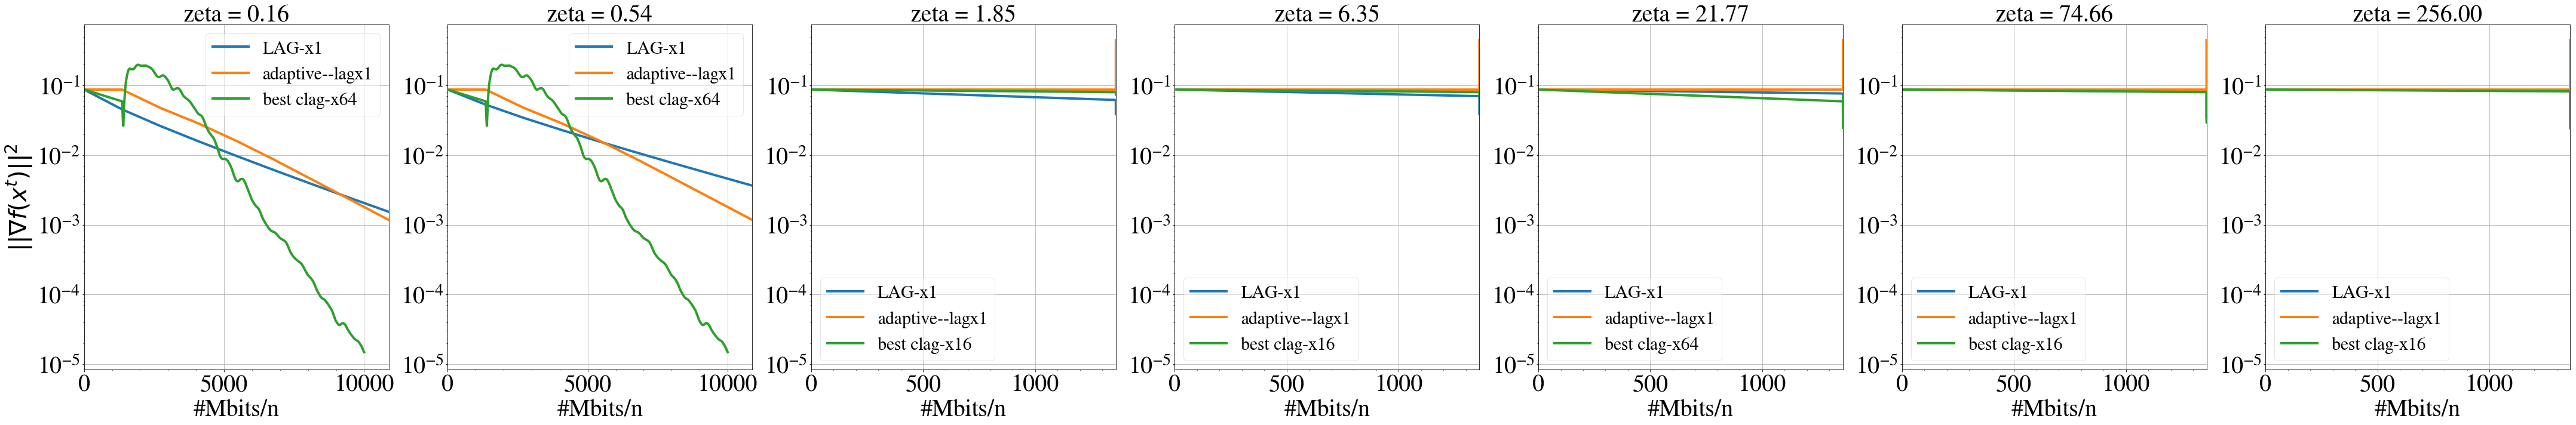

In [416]:
fig, ax = plt.subplots(nrows=1, ncols=len(zetas[4::]), figsize=(60, 10),
                       sharey=True)

k = ks[0]
for z_id, z in enumerate(zetas[4::]):
    # EF21
    comm_lag, norm_lag, scale_lag, c_lag = optimal_lag[(68, z)]
    ax[z_id].plot(comm_lag, norm_lag, label='LAG-x{}'.format(scale_lag),
                  markevery=int(len(comm_lag) / 10) + 2)
    # LAG
    acomm_lag, norm_lag, scale_lag, c_lag = optimal_adaptive[(d, z)]
    mask = np.isnan(norm_lag)
    ax[z_id].plot(np.array(acomm_lag)[~mask], np.array(norm_lag)[~mask], label='adaptive--lagx{}'.format(scale_lag),
                  markevery=int(len(comm_lag) / 10) + 2)
    comm_lag, norm_lag, scale_lag, c_lag = optimal_lag[(k, z)]
    ax[z_id].plot(comm_lag, norm_lag, label='best clag-x{}'.format(scale_lag),
                  markevery=int(len(comm_lag) / 10) + 2)
    locmin = tck.LogLocator(base=10.0, subs=(
        0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8), numticks=10)
    ax[z_id].set_yscale('log')
    ax[z_id].set_xlabel('#Mbits/n')
    ax[z_id].set_xlim(0,np.array(acomm_lag)[~mask][-1])
    if z_id == 0:
        ax[z_id].set_ylabel(r'$||\nabla f(x^t)||^2$')
    ax[z_id].legend(loc="best", framealpha=0.5)
    ax[z_id].grid()
    ax[z_id].locator_params(axis='x', nbins=4)
    ax[z_id].xaxis.set_minor_locator(tck.AutoMinorLocator(5))
    ax[z_id].yaxis.set_minor_locator(locmin)
    ax[z_id].yaxis.set_tick_params(which='both',
                                   direction='out',
                                   labelbottom=True)
    #ax[k_id].set_yticks(np.geomspace(1e-11, 1e-1, 6))
    ax[z_id].set_title('zeta = {:.2f}'.format(z))
    fig.show()
    fig.tight_layout()

In [151]:
with open('../results/histories_{}_False5.pickle'.format(dataset_name), 'rb') as file:
    histories_clag = pickle.load(file)
list(histories_clag.keys())

[(1, 0.0, 1),
 (1, 0.0, 4),
 (1, 0.0, 16),
 (1, 0.0, 64),
 (1, 0.0, 256),
 (1, 0.00390625, 1),
 (1, 0.00390625, 4),
 (1, 0.00390625, 16),
 (1, 0.00390625, 64),
 (1, 0.00390625, 256),
 (1, 0.013394437232079259, 1),
 (1, 0.013394437232079259, 4),
 (1, 0.013394437232079259, 16),
 (1, 0.013394437232079259, 64),
 (1, 0.013394437232079259, 256),
 (1, 0.04592920288361246, 1),
 (1, 0.04592920288361246, 4),
 (1, 0.04592920288361246, 16),
 (1, 0.04592920288361246, 64),
 (1, 0.04592920288361246, 256),
 (1, 0.1574901312368592, 1),
 (1, 0.1574901312368592, 4),
 (1, 0.1574901312368592, 16),
 (1, 0.1574901312368592, 64),
 (1, 0.1574901312368592, 256),
 (1, 0.5400298694461532, 1),
 (1, 0.5400298694461532, 4),
 (1, 0.5400298694461532, 16),
 (1, 0.5400298694461532, 64),
 (1, 0.5400298694461532, 256),
 (1, 1.8517494245745807, 1),
 (1, 1.8517494245745807, 4),
 (1, 1.8517494245745807, 16),
 (1, 1.8517494245745807, 64),
 (1, 1.8517494245745807, 256),
 (1, 6.349604207872803, 1),
 (1, 6.349604207872803, 4),
 

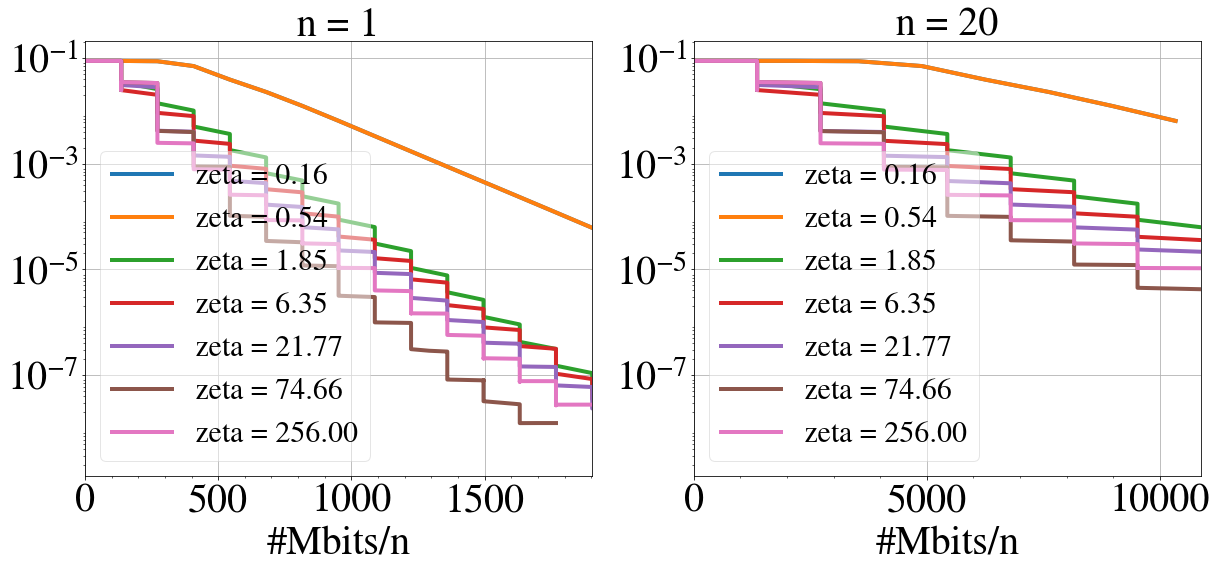

In [165]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8),
                       sharey=True)

n = [2,20]
nreal = [1,20]
for i, ax in enumerate(axes):
    for zeta in zetas[4:]:
        with open('../results/histories_{}_{}_{}_2604.pickle'.format(dataset_name, True, n[i]), 'rb') as file:
            histories_adaptive = pickle.load(file)
        optimal_adaptive = find_optimal_stepsize(histories_adaptive)
        acomm_lag, norm_lag, scale_lag, c_lag = optimal_adaptive[(68, zeta)]
        mask = np.isnan(norm_lag)
        ax.plot(np.array(acomm_lag)[~mask], np.array(norm_lag)[~mask], label='zeta = {:.2f}'.format(zeta),
                      markevery=int(len(comm_lag) / 10) + 2)
        ax.set_yscale('log')
        ax.set_xlabel('#Mbits/n')
        ax.set_xlim(0,np.array(acomm_lag)[~mask][-1])
        if z_id == 0:
            ax[z_id].set_ylabel(r'$||\nabla f(x^t)||^2$')
        ax.legend(loc="best", framealpha=0.5)
        ax.grid()
        ax.locator_params(axis='x', nbins=4)
        ax.xaxis.set_minor_locator(tck.AutoMinorLocator(5))
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_tick_params(which='both',
                                       direction='out',
                                       labelbottom=True)
        ax.set_title('n = {}'.format(nreal[i]))

In [230]:
np.array(comm_lag)[mask]

array([4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284,
       4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284,
       4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284,
       4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284,
       4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284,
       4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284,
       4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284,
       4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284,
       4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284,
       4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284,
       4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284,
       4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284,
       4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284, 4284,
       4284, 4284, 4284, 4284, 4284, 4284, 4284, 42